In [1]:
import os 
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB


In [2]:
# data = pd.read_excel('NY_Vehicle_Motor_2017.xlsx')
data = pd.read_excel('data/final.xlsx')

In [3]:
data.columns=[c.replace(' ','_') for c in data.columns]
columns = ['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LAT', 'LONG',
       'LOC', 'ON_ST', 'CROSS_ST', 'OFF_ST',
       'NUM_INJ', 'NUM_KILL',
       'NUM_PED_INJ', 'NUM_PED_KILL',
       'NUM_CYC_INJ', 'NUM_CYC_KILL',
       'NUM_MOT_INJ', 'NUM_MOT_KILL',
       'CF1', 'CF2',
       'CF3', 'CF4',
       'CF5', 'UNIQUE KEY', 'VC1',
       'VC2', 'VC3', 'VC4',
       'VC5','YEAR','TEMP', 'WIND', 'PREC', 'SPEED']

data.columns = columns

df = data.drop(['LOC','ON_ST', 'CROSS_ST', 
                  'OFF_ST','NUM_PED_INJ', 'NUM_PED_KILL',
       'NUM_CYC_INJ', 'NUM_CYC_KILL',
       'NUM_MOT_INJ', 'NUM_MOT_KILL','ZIP CODE','LAT','LONG','UNIQUE KEY','CF3', 'CF4',
       'CF5','VC3', 'VC4',
       'VC5','YEAR'], 1) # Dropped a CF3,4,5 and VC3,4,5 because majority of the values are NaN
df['CASUALTIES'] = df['NUM_KILL']
df['LABEL'] = df.eval("CASUALTIES >0 ")
df['TIME'] = pd.to_datetime(df['TIME'], format='%H:%M').dt.time
df = df.drop(['CF2','NUM_INJ','NUM_KILL'],1)
df['MONTH'] = df['DATE'].apply(lambda x : x.split('/')[0]) # New Column of Month
df['MONTH'] = pd.to_numeric(df['MONTH'], errors='coerce')

import datetime

df['HOUR'] = df['DATE'].map(str) + " " + df['TIME'].map(str)
df['HOUR']=pd.to_datetime(df['HOUR'])
df['HOUR'] = df['HOUR'].dt.round('H').dt.hour

df['PART_OF_DAY']=df['HOUR']
df['PART_OF_DAY']=df['PART_OF_DAY'].replace({k: 'M' for k in [5,6,7,8,9,10,11,12]})
df['PART_OF_DAY']=df['PART_OF_DAY'].replace({k: 'A' for k in [13,14,15,16,17]})
df['PART_OF_DAY']=df['PART_OF_DAY'].replace({k: 'E' for k in [18,19,20,21]})
df['PART_OF_DAY']=df['PART_OF_DAY'].replace({k: 'N' for k in [22,23,24,1,2,3,4,0]})
df = df.drop(['DATE','CASUALTIES','TIME','HOUR'],1)

In [4]:
df = df.replace(np.NaN, 'na')
causes_categories  = {'Driver Inattention/Distraction':1                      
,'Following Too Closely' : 2                                  
,'Failure to Yield Right-of-Way':2                           
,'Backing Unsafely': 2                                        
,'Passing or Lane Usage Improper' :2                         
,'Unsafe Lane Changing' : 2                                    
,'Other Vehicular' :  6                                          
,'Turning Improperly' : 2                                     
,'Traffic Control Disregarded' :2                               
,'Driver Inexperience' : 1                                     
,'Reaction to Other Uninvolved Vehicle'   : 1                   
,'Unsafe Speed'  : 2                                            
,'Alcohol Involvement' : 4                                       
,'Pavement Slippery'  : 5                                       
,'View Obstructed/Limited':5                                   
,'Oversized Vehicle' : 6                                        
,'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion' : 5    
,'Aggressive Driving/Road Rage' :3                               
,'Passenger Distraction': 1                                      
,'Brakes Defective': 6                                           
,'Fell Asleep' : 4                                                
,'Outside Car Distraction' : 1                                   
,'Obstruction/Debris' : 5                                      
,'Glare' : 5                                                    
,'Failure to Keep Right' : 2                                    
,'Steering Failure' : 6                                          
,'Fatigued/Drowsy' : 4                                          
,'Driverless/Runaway Vehicle' : 5                                
,'Tire Failure/Inadequate' : 6                                
,'Pavement Defective' : 5                                        
,'Illness' : 4                                                    
,'Lost Consciousness' : 4                                         
,'Animals Action' : 5                                            
,'Drugs (Illegal)' : 4                                        
,'Accelerator Defective' : 6                                    
,'Lane Marking Improper/Inadequate' : 5                          
,'Cell Phone (hand-held)': 1                                      
,'Traffic Control Device Improper/Non-Working': 5          
,'Physical Disability' :4                            
,'Other Electronic Device' : 1                                    
,'Tow Hitch Defective' : 6                                        
,'Prescription Medication' :4                                    
,'Other Lighting Defects' :6                                     
,'Headlights Defective' : 6                                       
,'Cell Phone (hands-free)' : 1                                     
,'Shoulders Defective/Improper' : 5                                
,'Windshield Inadequate': 6                                        
,'Passing Too Closely':2 
, 'na' : 999
, 'Unspecified': 0
            }
df.CF1 = [causes_categories[item] for  item in df.CF1]

In [5]:
bor = {'BRONX':1 , 'BROOKLYN':2,'MANHATTAN':3, 'QUEENS':4, 'STATEN ISLAND':5, 'na':999}
df.BOROUGH = [bor[item] for  item in df.BOROUGH]

In [6]:
df_vehicle=df

In [7]:
df_vehicle['VC1']=df_vehicle['VC1'].replace({k: 'PV' for k in
                                             ['PASSENGER VEHICLE','DS','Sedan','TAXI','AM','SPORT UTILITY / STATION WAGON','LL'
                                             ,'AMBUL','CONV','utili','PK','Backh','PEDICAB','P/SE','Ford','ambul','3D',
                                             'ambu','MB','LIVER','TRUCK','PICK-UP TRUCK','TK','TR','trk','Station Wagon/Sport Utility Vehicle'
                                             ,'FORD','Pick','AMB','truck','pick','Ambul','ABULA','PEDIC','MK','subn','omni','Taxi','OML'
                                             ,'Humme','RENTA','VT','NYPD','SUBUR','Truck','PICKU','VC','light','TRLPM','Ice C','ST150'
                                             ,'315 e','Pick-up Truck','SUV','Ambulance','BACKH']})
df_vehicle['VC1']=df_vehicle['VC1'].replace({k: 'CT' for k in
                                             ['FB','BU','DP','van','VN','TN','TT','TRACT','RV','CB','AR',
                                             'BR','RF','VAN','UHAUL','GG','forkl','CM','POSTA','Trail','van t','FIRE TRUCK','fire'
                                             ,'TRAIL','USPS','FORKL','schoo','SCHOO','TOW','Fire','FIRET','COMME','FR','armor','posta'
                                             ,'dp','ST','DUMP','BUS','deliv','BUs','VAN/T','Van','DELIV','FDNY','UPS t','deliv','garba',
                                             'SANIT','FLAT','Schoo','Tow t','CARGO','UTILI','MTA B','NYC B','cemen','COM','TRANS'
                                             ,'GARBA','cargo','TOW T','REFRI','VANG','SEMI','trail','UT','COM T','MACK','AMBULANCE'
                                             ,'sanit','UTIL','Bus','Util','TRAC','BOX T','Utili','bus','Flat Bed','Tractor Truck Diesel'
                                             ,'Box Truck','Dump','FORK','DELV','tank','elect','ELECT','POWER','power','fork','com','dump']})
df_vehicle['VC1']=df_vehicle['VC1'].replace({k: 'BP' for k in
                                             ['BICYCLE','MOTORCYCLE','SKATE','MOTOR','MS','MD','MOPED','SCOOTER','SELF','motor','FLATB'
                                             ,'Bike','EBIKE','E-BIK']})
df_vehicle['VC1']=df_vehicle['VC1'].replace({k: 'OE' for k in
                                             ['EN','sciss','LF','PSD','SP','STREE','MK','UNKNO','Golf'
                                             ,'John','PL','ladde','IP','SPC','CO','BA','PSR','refg','REP','unk','GE/SC','Mo pa'
                                             ,'CABIN','BACK','Comme','east','UNKNOWN','LW','SE','OP','unkno']})
df_vehicle['VC1']=df_vehicle['VC1'].fillna('None')

In [8]:
df_vehicle['VC2']=df_vehicle['VC2'].replace({k: 'PV' for k in
                                             ['PASSENGER VEHICLE','DS','Sedan','TAXI','AM','SPORT UTILITY / STATION WAGON','LL'
                                             ,'AMBUL','CONV','utili','PK','Backh','PEDICAB','P/SE','Ford','ambul','3D',
                                             'ambu','MB','LIVER','TRUCK','PICK-UP TRUCK','TK','TR','trk','Station Wagon/Sport Utility Vehicle'
                                             ,'FORD','Pick','AMB','truck','pick','Ambul','ABULA','PEDIC','MK','subn','omni','Taxi','OML'
                                             ,'Humme','RENTA','VT','NYPD','SUBUR','Truck','PICKU','VC','light','TRLPM','Ice C','ST150'
                                             ,'315 e','Pick-up Truck','SUV','Ambulance','BACKH','WAGON','VAN T','4 dr sedan','AMULA'
                                             ,'omnib','Subn','CAB','amb','MAIL']})
df_vehicle['VC2']=df_vehicle['VC2'].replace({k: 'CT' for k in
                                             ['FB','BU','DP','van','VN','TN','TT','TRACT','RV','CB','AR',
                                             'BR','RF','VAN','UHAUL','GG','forkl','CM','POSTA','Trail','van t','FIRE TRUCK','fire'
                                             ,'TRAIL','USPS','FORKL','schoo','SCHOO','TOW','Fire','FIRET','COMME','FR','armor','posta'
                                             ,'dp','ST','DUMP','BUS','deliv','BUs','VAN/T','Van','DELIV','FDNY','UPS t','deliv','garba',
                                             'SANIT','FLAT','Schoo','Tow t','CARGO','UTILI','MTA B','NYC B','cemen','COM','TRANS'
                                             ,'GARBA','cargo','TOW T','REFRI','VANG','SEMI','trail','UT','COM T','MACK','AMBULANCE'
                                             ,'sanit','UTIL','Bus','Util','TRAC','BOX T','Utili','bus','Flat Bed','Tractor Truck Diesel'
                                             ,'Box Truck','Dump','FORK','DELV','tank','elect','ELECT','POWER','power','fork','com','dump'
                                             ,'Crane','TRACK','Tank','Elect','Tract','TANK','comm','FREIG','tow t','semi','SEMI-'
                                             ,'comme']})
df_vehicle['VC2']=df_vehicle['VC2'].replace({k: 'BP' for k in
                                             ['BICYCLE','MOTORCYCLE','SKATE','MOTOR','MS','MD','MOPED','SCOOTER','SELF','motor','FLATB'
                                             ,'Bike','EBIKE','E-BIK','Motorcycle','scoot','Motor','E BIK','Scoot','moped']})
df_vehicle['VC2']=df_vehicle['VC2'].replace({k: 'OE' for k in
                                             ['EN','sciss','LF','PSD','SP','STREE','MK','UNKNO','Golf'
                                             ,'John','PL','ladde','IP','SPC','CO','BA','PSR','refg','REP','unk','GE/SC','Mo pa'
                                             ,'CABIN','BACK','Comme','east','UNKNOWN','LW','SE','OP','unkno','horse'
                                             ,'Unkno','tr','BOBCA','REFG','EMS','uliti','SBN','Pavin','OTHER','NYC F','GOV V','P/SH','MH','TAN P','SPRIN',
                                              'APPOR','omr','dsny','UD','tk','nissa','G OMR','carri','Carry All','DELV.',
                                              'EB','White','15 PA','INTER','OLM','PAS','ROAD','firet','bobca','HINO',
                                              'utlit','Car C','red,','CONST','scaff','picku','TANDU',
                                              'Stree','Self','Road','detac','PM','US Po','CAT 4','1S','RUBBE','BOOM','DOT #','FORTL','small','US Po']})
#df_vehicle['VC2']=df_vehicle['VC2'].fillna('None')


In [9]:
df_vehicle['VC1']=df_vehicle['VC1'].fillna('PV')
df_vehicle["Vehicle_Involvement"]=df_vehicle['VC1'].map(str) + "-" + df_vehicle['VC2'].map(str)

df_vehicle['Vehicle_Involvement']=df_vehicle['Vehicle_Involvement'].replace({k: 'CT-PV' for k in ['PV-CT']})
df_vehicle['Vehicle_Involvement']=df_vehicle['Vehicle_Involvement'].replace({k: 'PV-BP' for k in ['BP-PV']})
df_vehicle['Vehicle_Involvement']=df_vehicle['Vehicle_Involvement'].replace({k: 'PV-OE' for k in ['OE-PV']})
df_vehicle['Vehicle_Involvement']=df_vehicle['Vehicle_Involvement'].replace({k: 'CT-OE' for k in ['OE-CT']})
df_vehicle['Vehicle_Involvement']=df_vehicle['Vehicle_Involvement'].replace({k: 'CT-BP' for k in ['BP-CT']})
df_vehicle['Vehicle_Involvement']=df_vehicle['Vehicle_Involvement'].replace({k: 'PV' for k in ['PV-nan']})
df_vehicle['Vehicle_Involvement']=df_vehicle['Vehicle_Involvement'].replace({k: 'CT' for k in ['CT-nan']})
df_vehicle['Vehicle_Involvement']=df_vehicle['Vehicle_Involvement'].replace({k: 'BP' for k in ['BP-nan']})
df_vehicle['Vehicle_Involvement']=df_vehicle['Vehicle_Involvement'].replace({k: 'OE' for k in ['OE-nan']})

In [10]:
df_vehicle = df_vehicle.drop(['VC1','VC2'],1)

In [11]:
vi = {'PV-na':1, 'PV-PV':2, 'CT-PV':3, 'PV-BP':4, 'na-na':5, 'CT-na':6, 'CT-CT':7,
       'BP-na':8, 'PV-OE':9, 'CT-BP':10, 'CT-OE':11, 'na-PV':12, 'BP-BP':13, 'OE-na':14,
       'OE-OE':15, 'na-BP':16}
df_vehicle.Vehicle_Involvement = [vi[item] for  item in df.Vehicle_Involvement]


In [12]:
pod = {'M':1, 'A':2 , 'E':3 , 'N':4}
df_vehicle.PART_OF_DAY = [pod[item] for  item in df.PART_OF_DAY]

In [13]:
df_final = df_vehicle
df_final['CF1'].replace( 999,2, inplace= True)
df_final['BOROUGH'].replace( 999,2 ,inplace= True)

In [14]:
cf1 = df_final['BOROUGH'].value_counts()
cf1

2    132113
4     38388
3     31512
1     21197
5      6214
Name: BOROUGH, dtype: int64

In [15]:
df_final.head()

,BOROUGH,CF1,TEMP,WIND,PREC,SPEED,LABEL,MONTH,PART_OF_DAY,Vehicle_Involvement
103919,2,5,15,17,0.0,25,False,12,4,1
194671,2,0,15,17,0.0,25,False,12,4,1
194693,1,0,15,17,0.0,25,False,12,4,1
194694,3,0,15,17,0.0,35,False,12,4,1
194695,4,1,15,17,0.0,35,False,12,4,2


In [16]:
train_pct = 0.8
#1. create an array of n random uniform variables drawn on [0,1] range
rand = np.random.rand(df_final.shape[0])
#2. Convert to boolean where True = random number < train_pct
rand_filt = (rand < train_pct)

#Use the filter to index data

train_df = df_final[rand_filt]
test_df = df_final[(rand_filt == False)]


In [17]:
Y_train = train_df['LABEL']
X_train = train_df.drop('LABEL', 1)

Y_test = test_df['LABEL']
X_test = test_df.drop('LABEL', 1)

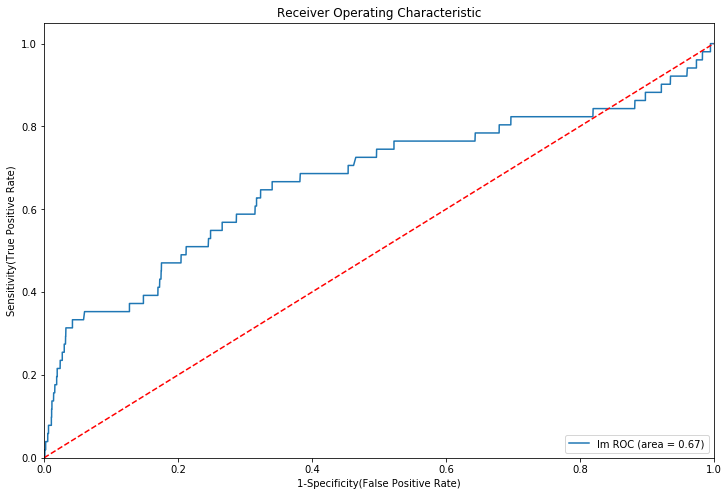

In [18]:
from sklearn import metrics
plt.figure(figsize = (12, 8))

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'lm',
    'model': LogisticRegression(C=1e30),
}
]

# Below for loop iterates through our models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, Y_train) # train the model
    Y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(Y_test,model.predict_proba(X_test)[:,1])
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

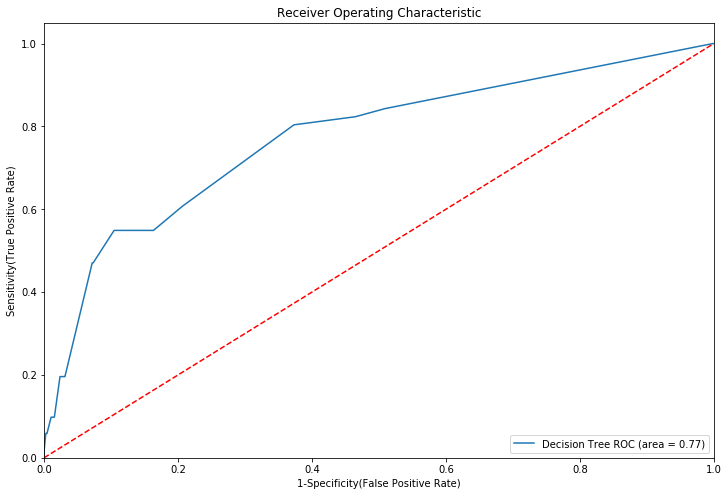

In [19]:
#decision_tree = BernoulliNB()
from sklearn.ensemble import RandomForestClassifier
plt.figure(figsize = (12, 8))
#decision_tree = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
decision_tree = DecisionTreeClassifier(max_depth=5, random_state=0)
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, decision_tree.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
auc = metrics.roc_auc_score(Y_test,decision_tree.predict_proba(X_test)[:,1])
# Now, plot the computed values
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('Decision Tree', auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

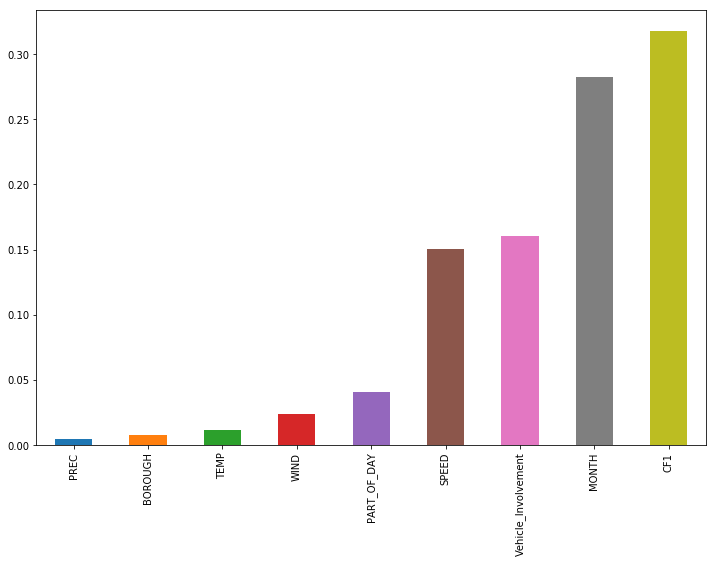

In [20]:
importances = decision_tree.feature_importances_
output_data = pd.DataFrame(index = X_train.columns, columns = ['value'])
output_data['value'] = importances
# #Sort the values 
output_data = output_data.sort_values('value')
output_data.value.plot(kind='bar', figsize = (12, 8))

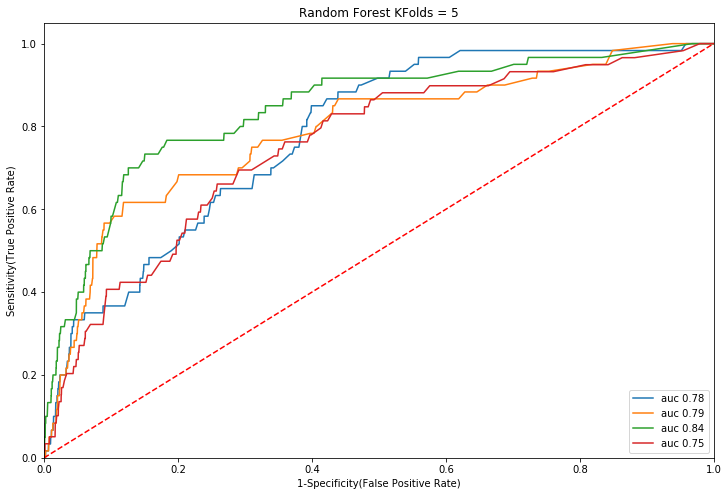

In [21]:
from sklearn.model_selection import StratifiedKFold
plt.figure(figsize = (12, 8))
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
cv = StratifiedKFold(n_splits=4, random_state=None, shuffle=False)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
X = df_final.drop(['LABEL'], 1)
y = df_final['LABEL']
for (train, test), i in zip(cv.split(X, y), range(4)):
    clf.fit(X.iloc[train], y.iloc[train])
    fpr, tpr, thresholds = metrics.roc_curve(y.iloc[test], clf.predict_proba(X.iloc[test])[:,1])
    auc_score = metrics.roc_auc_score(y.iloc[test], clf.predict_proba(X.iloc[test])[:,1])
    scores.append(auc_score)
    fprs.append(fpr)
    tprs.append(tpr)
    plt.plot(fpr, tpr, label='auc %0.2f' % (auc_score))
#     plt.plot(fprtr, tprtr, label='%s ROC_train(area = %0.2f)' % (m['label'], auctr))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Random Forest KFolds = 5')
plt.legend(loc="lower right")
plt.show()

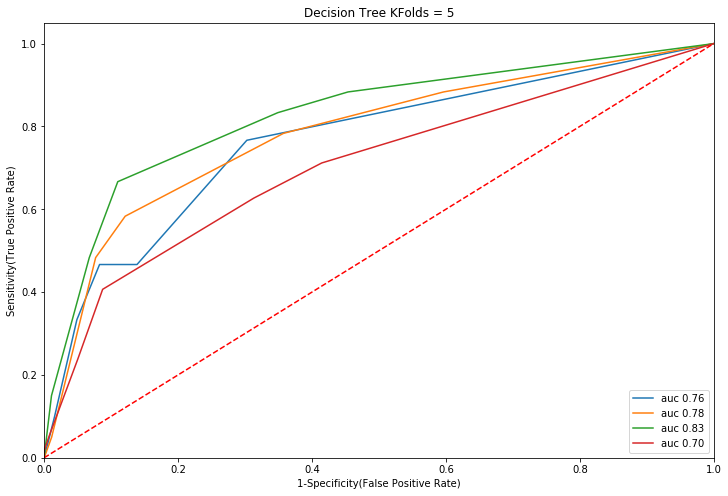

In [22]:
plt.figure(figsize = (12, 8))
clf = DecisionTreeClassifier(max_depth=3, random_state=0)
cv = StratifiedKFold(n_splits=4, random_state=None, shuffle=False)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
X = df_final.drop(['LABEL'], 1)
y = df_final['LABEL']
for (train, test), i in zip(cv.split(X, y), range(4)):
    clf.fit(X.iloc[train], y.iloc[train])
    fpr, tpr, thresholds = metrics.roc_curve(y.iloc[test], clf.predict_proba(X.iloc[test])[:,1])
    auc_score = metrics.roc_auc_score(y.iloc[test], clf.predict_proba(X.iloc[test])[:,1])
    scores.append(auc_score)
    fprs.append(fpr)
    tprs.append(tpr)
    plt.plot(fpr, tpr, label='auc %0.2f' % (auc_score))
#     plt.plot(fprtr, tprtr, label='%s ROC_train(area = %0.2f)' % (m['label'], auctr))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Decision Tree KFolds = 5')
plt.legend(loc="lower right")
plt.show()

In [23]:
import sklearn.datasets as datasets
iris=datasets.load_iris()

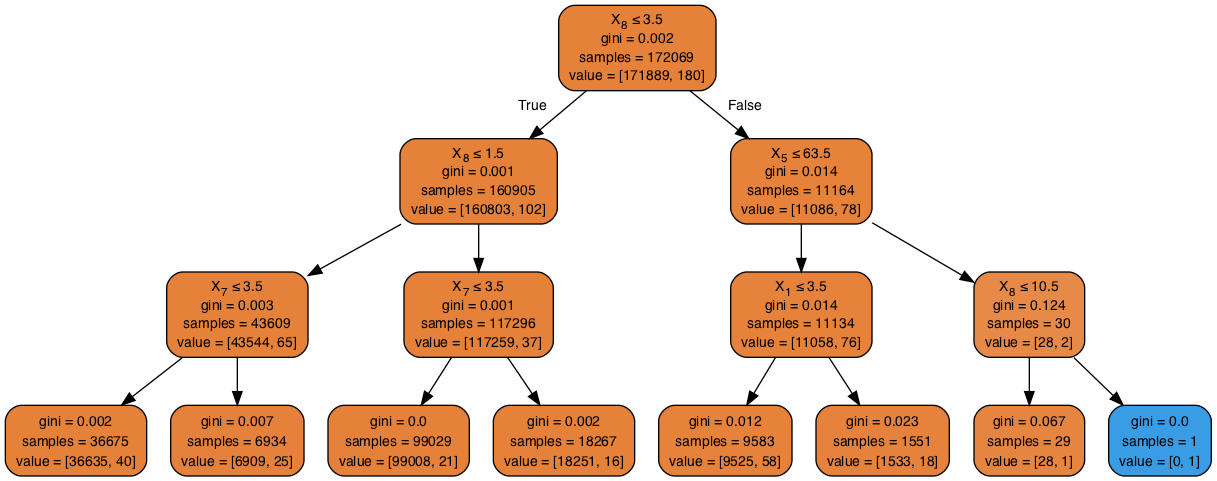

In [24]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image 

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [25]:
X.head()

,BOROUGH,CF1,TEMP,WIND,PREC,SPEED,MONTH,PART_OF_DAY,Vehicle_Involvement
103919,2,5,15,17,0.0,25,12,4,1
194671,2,0,15,17,0.0,25,12,4,1
194693,1,0,15,17,0.0,25,12,4,1
194694,3,0,15,17,0.0,35,12,4,1
194695,4,1,15,17,0.0,35,12,4,2


In [32]:
from pandas.plotting import scatter_matrix

df_final.describe()

,BOROUGH,CF1,TEMP,WIND,PREC,SPEED,MONTH,PART_OF_DAY,Vehicle_Involvement
count,229424.000000,229424.000000,229424.000000,229424.000000,229424.000000,229424.000000,229424.000000,229424.000000,229424.000000
mean,2.460863,1.521140,41.162337,10.639488,0.015217,29.268006,6.642614,2.190882,1.950768
std,0.964580,1.440442,6.699978,2.022241,0.160309,8.794288,3.395184,1.050724,1.010549
min,1.000000,0.000000,15.000000,7.000000,0.000000,5.000000,1.000000,1.000000,1.000000
25%,2.000000,0.000000,40.000000,10.000000,0.000000,25.000000,4.000000,1.000000,1.000000
50%,2.000000,1.000000,40.000000,10.000000,0.000000,25.000000,7.000000,2.000000,2.000000
75%,3.000000,2.000000,40.000000,10.000000,0.000000,30.000000,10.000000,3.000000,2.000000
max,5.000000,6.000000,74.000000,24.000000,3.030000,120.000000,12.000000,4.000000,16.000000


In [103]:
boxes = df_final[['MONTH', 'Vehicle_Involvement', 'CF1', 'SPEED', 'BOROUGH', 'PART_OF_DAY']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21945a90>,
      dtype=object)

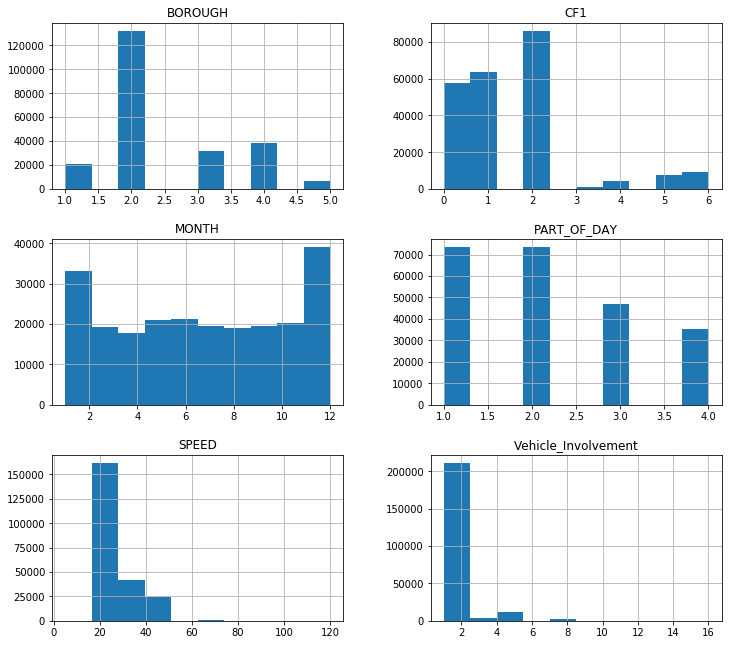

In [104]:
boxes.hist(figsize=(12, 11))